## Trying out MLFlow

### Imports

In [12]:
import os
import torch
import random as r
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

### Model

In [11]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0) 
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16*4*4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        
        x = self.pool(self.relu(self.conv1(x))) # 1x28x28 -> 6x24x24 -> 6x12x12
        x = self.pool(self.relu(self.conv2(x))) # 6x12x12 -> 16x8x8 -> 16x4x4
        x = x.view(-1, 16*4*4) # 16x4x4 -> 256
        x = self.relu(self.fc1(x)) # 256 -> 64
        x = self.relu(self.fc2(x)) # 64 -> 32
        x = self.fc3(x) # 32 -> 10
        return x

### Helper Functions

In [16]:
train_dataset = ImageFolder("data/training", transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),
    transforms.ToTensor()
]))

test_dataset = ImageFolder("data/testing", transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
]))

In [17]:
def train_epoch(model:nn.Module, device, train_loader, criterion, optimizer):
    model.train()
    train_loss_epoch = 0
    train_acc_epoch = 0
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()
        train_acc_epoch += (y_pred.argmax(1) == y).float().item()
    return train_loss_epoch / len(train_loader), train_acc_epoch / len(train_loader)

def test_epoch(model:nn.Module, device, test_loader, criterion):
    model.eval()
    test_loss_epoch = 0
    test_acc_epoch = 0
    for x, y in tqdm(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss_epoch += loss.item()
        test_acc_epoch += (y_pred.argmax(1) == y).float().item()
    return test_loss_epoch / len(test_loader), test_acc_epoch / len(test_loader)

In [18]:
def train(model:nn.Module, device, train_loader, test_loader, criterion, optimizer, epochs):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    model.to(device)
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    best_acc = 0
    best_acc_epoch = 0
    best_loss = float("inf")
    best_loss_epoch = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}:")
        train_loss_epoch, train_acc_epoch = train_epoch(model, device, train_loader, criterion, optimizer)
        print(f"Train loss: {train_loss_epoch}, Train accuracy: {train_acc_epoch}")
        test_loss_epoch, test_acc_epoch = test_epoch(model, device, test_loader, criterion)
        print(f"Test loss: {test_loss_epoch}, Test accuracy: {test_acc_epoch}")
        train_loss.append(train_loss_epoch)
        train_acc.append(train_acc_epoch)
        test_loss.append(test_loss_epoch)
        test_acc.append(test_acc_epoch)
        epoch_stats = pd.DataFrame({
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc
        }, index=range(1, epoch+2))
        epoch_stats.to_csv("results/epoch_stats.csv")
        
        if test_acc_epoch > best_acc:
            torch.save(model.state_dict(), f"models/best_acc_model.pth")
            best_acc = test_acc_epoch
            best_acc_epoch = epoch + 1
            
        if test_loss_epoch < best_loss:
            torch.save(model.state_dict(), "models/best_loss_model.pth")
            best_loss = test_loss_epoch
            best_loss_epoch = epoch + 1
        general_stats = pd.DataFrame({
            "best_acc": [best_acc],
            "best_acc_epoch": [best_acc_epoch],
            "best_loss": [best_loss],
            "best_loss_epoch": [best_loss_epoch]
        })
        general_stats.to_csv("results/general_stats.csv")
    

In [31]:
def predict_one(model:nn.Module, device, x):
    model.to(device)
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        y_pred = model(x.unsqueeze(0))
        return y_pred.argmax(1).item()

### Training Code

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
random_num = r.randint(0, 10000)
test_image, test_label = test_dataset[random_num]

plt.imshow(test_image, cmap="gray")
plt.title(f"True label: {test_label}")
plt.show()

In [ ]:
model = LeNet5()
device = "cuda" if torch.cuda.is_available() else "cpu"


num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
train(model, device, train_loader, test_loader, criterion, optimizer, num_epochs)

In [ ]:
prediction = predict_one(model, device, test_image)

plt.imshow(test_image, cmap="gray")
plt.title(f"True label: {test_label}, Predicted label: {prediction}")
plt.show()

### Prediction Code

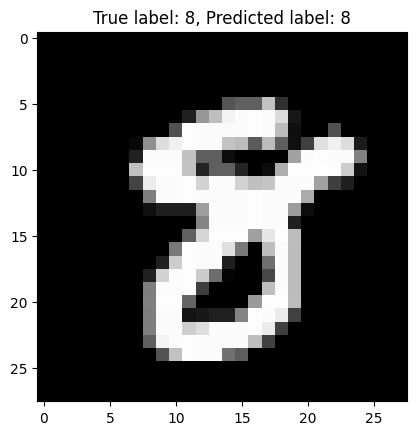

In [46]:
model = LeNet5()

state_dict = torch.load("models/best_acc_model.pth")
model.load_state_dict(state_dict)

device = "cuda" if torch.cuda.is_available() else "cpu"

random_num = r.randint(0, 10000)
test_image, test_label = test_dataset[random_num]

prediction = predict_one(model, device, test_image)

plt.imshow(test_image[0], cmap="gray")
plt.title(f"True label: {test_label}, Predicted label: {prediction}")
plt.show()
